In [1]:
from OpInf import *
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from scipy.io import loadmat
from operators import ckron, ckron_indices

In [2]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [3]:
mus = [1.1, 1.05, 1, 0.95, 0.9]
# Load data

p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    "N": 2**7 + 1 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "BE",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [4]:
Train_T = int(T_end/dt)
X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")[:, :Train_T+1, :]
# X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")
print(X_all.shape)

(5, 2001, 130)


In [5]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [6]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


max idx =  5
max idx =  8
max idx =  11
max idx =  14


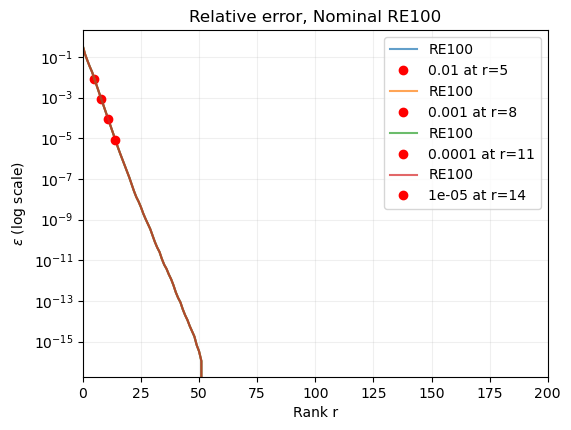

In [9]:
err_tols = [1e-2, 1e-3, 1e-4, 1e-5]
names = [f"mu = {mu}" for mu in mus]
max_idx_lst = []
# mus = [0.01] # only one mu for now
fig, ax = plt.subplots(figsize=(6, 4.5))
for err_tol in err_tols:
    rob_lst = []
    rel_err_SVD_lst = []
    idx_lst = []
    
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    # print("X = ", X.shape)
    # print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    # print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    
    # ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(rel_err_SVD, label="RE100", linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol} at r={idx}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal RE100")
    ax.legend()
        

    print("max idx = ", max(idx_lst))
    max_idx_lst.append(max(idx_lst))

In [7]:
# Model parameters
r = 14
q_trunc = 20
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(1):
    # Procustes problem for each mu
    X = np.concatenate([X_all[i, :, :] for i in range(Mp)], axis=0).T
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    X_ref = np.mean(X, axis=1)[:, None]
    # X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r+q_trunc]
    q = Vr.T @ X_centered
    Proj_error = X_centered - (Vr @ q)
    Poly = np.concatenate(polynomial_form(q, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  10005
X =  (130, 10005)

Reconstruction error: 0.3172%


In [8]:
Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")


Reconstruction error: 0.3172%


In [9]:
q.shape

(14, 10005)

In [10]:
Mp = len(mus)
Nsnapshots = X.shape[1]
dShatdt = []
Shat_lst = []
dSdt = []
for j in range(Mp):
    start_ind = int((j) * Nsnapshots/Mp)
    end_ind = int((j+1) * Nsnapshots/Mp)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='BE')
    ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="BE")
    dShatdt.append(ddtshat)
    ind = np.array(ind) + int((j) * Nsnapshots/Mp)
    Shat_lst.append(q[:, ind])
    dSdt.append(ddts)
    

start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [11]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


In [12]:
def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

Shat_py = np.concatenate(Shat_lst, axis=1)
dShatdt_py = np.concatenate(dShatdt, axis=1).T
dSdt_py = np.hstack(dSdt)

print("Shape of Shat_py: ", Shat_py.shape)
print("Shape of dShatdt_py: ", dShatdt_py.shape)
# [operators] = inferOperators_NL(Shat, U, params, dShatdt);

operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
# operators = infer_operators_nl(q, None, config['params'], /dShatdt_py)

Shape of Shat_py:  (14, 10000)
Shape of dShatdt_py:  (10000, 14)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.05 0.05 100
Solving...
Solved!


In [13]:
config['robparams'] = {
    "r": int(r)
}

N = int(config['N'])
dt = config['dt']
T_end = config['T_end']
mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
Mp = config['Mp']
K = int(config['K'])
DS = config['DS']
params = config['params']  # This will be a dictionary in Python
robparams = config['robparams']  # This will be a dictionary in Python


coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1]

# regs = [1e1, 3e3, 1e9]
# regs = [0.001, 20, 1e5]
Shat_true = Shat_lst[2]
regs_product = [1e-3, 1e-3, 1, 1e1, 1e4, 5, 1e3, 1e7, 5]
# regs_product = [1e-3, 1e-3, 1, 23, 60, 10]
# regs_product = [1e-3, 1e-2, 5, 1e-3, 1e-2, 5, 1e-3, 1e-1, 5]
# regs, operators = train_minimize(Shat_py, dShatdt_py, Shat_true, train_size, r, regs, time_domain, q0, params, testsize=None, margin=1.1)
regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)


coord =  (130,)
Constructing least-squares solver, r=14
TRAINING 25 ROMS
(1/25) Testing ROM with (0.001, 10.0, 1000.0)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.001 10.0 1000.0
Solving...
Solved!
Integrating...
Bound check passed
(2/25) Testing ROM with (0.001, 10.0, 10000.0)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.001 10.0 10000.0
Solving...
Solved!
Integrating...
Bound check passed
(3/25) Testing ROM with (0.001, 10.0, 100000.0)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.001 10.0 100000.0
Solving...
Solved!
Integrating...
Bound check passed
(4/25) Testing ROM with (0.001, 10.0, 1000000.0)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.001 10.0 1000000.0
Solving...
Solved!
Integrating...
Bound check passed
(5/25) Testing ROM with (0.001, 10.0, 10000000.0)
Generating ghat ...
drp:  301
Obtained data matrix...
Regularization 

In [15]:
print("Errors:, ", errors)
print("regs: ", regs)

Errors:,  0.01185114239564109
regs:  [0.001, 10.0, 10000000.0]


In [16]:
# regs = [0.0005399173326341194, 23.61197176062329, 202651972.5062846]

params['lambda1'] = regs[0]
params['lambda2'] = regs[1]
if len(regs) > 2:
    params['lambda3'] = regs[2]

# params['lambda1'] = (5e-2)**2
# params['lambda2'] = (5e-2)**2
# if len(regs) > 2:
#     params['lambda3'] = regs[2]
operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)

Generating ghat ...
drp:  301
Obtained data matrix...
Regularization parameters:  0.001 10.0 10000000.0
Solving...
Solved!


In [17]:
modelform = config['params']['modelform']

def rhs(t, state, operators, multi_indices, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
    # print("Solving for regularization parameters: ", params['lambda1'], params['lambda2'], params['lambda3'])
    
    if 'L' in modelform:
        # print("adding A")
        out += operators['A'] @ state
    
    if 'Q' in modelform:
        # ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
        # out += operators['F'] @ ssq.flatten()
        # print("adding F")
        mask = ckron_indices(state.shape[0])
        out += (operators["F"] @ np.prod(state[mask], axis=1))
        
    if 'P' in modelform:
        gs = gen_poly(state[:, None], p=p, multi_indices=multi_indices)  # Assuming gen_poly is designed for column vector input
        out += (operators['P'] @ gs).flatten()
        
    if 'C' in modelform:
        out += operators['C'].flatten()
    
    return out

coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
time_domain = np.arange(0, T_end, dt)
train_size = Shat_py.shape[1]

multi_indices = generate_multi_indices_efficient(len(q0), p=p)

out = scipy.integrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain[0], time_domain[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain,  # evaluated at these points
            args=[operators, multi_indices, None],  # additional arguments to rhs
        )

coord =  (130,)


In [18]:
# N = int(config['N'])
# dt = config['dt']
# T_end = config['T_end']
# mus = config['mus']  # Assuming mus is saved as a string that represents a Python expression
# Mp = config['Mp']
# K = int(config['K'])
# DS = config['DS']
# params = config['params']  # This will be a dictionary in Python
# robparams = config['robparams']  # This will be a dictionary in Python

# Chat= operators['C']
# Ahat = operators['A']
# Bhat = operators['B']
# Fhat = operators['F']
# Phat = operators['P']



# def initial_condition(coord):
#     if coord <= 0.5:
#         return np.sin(2 * np.pi * coord)
    
#     return 0

# # coordinates are equally spaced points from 0 to 1 with 2^7 + 1 points
# N = 2**7 + 1 + 1
# coord = np.linspace(0, 1, N)
# print("coord = ", coord.shape)
# IC = np.array([initial_condition(c) for c in coord])
# q0 = Vr.T @ IC
# time_domain = np.arange(0, T_end, dt)

# import scipy.integrate as spintegrate
# # s_hat = semi_implicit_euler_poly_gen(Chat, Ahat, Fhat, Phat, dt, num_snapshots, Vr.T @ IC, p=p)

# def rhs(t, state, input_func=None):
#     r"""Evaluate the right-hand side of the model by applying each operator
#     and summing the results.

#     This is the function :math:`\Ophat(\qhat, \u)`
#     where the model can be written as one of the following:

#     * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
#     * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
#     * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

#     Parameters
#     ----------
#     state : (r,) ndarray
#         State vector.
#     input_ : (m,) ndarray or None
#         Input vector corresponding to the state.

#     Returns
#     -------
#     evaluation : (r,) ndarray
#         Evaluation of the right-hand side of the model.
#     """
#     state = np.atleast_1d(state)
    
#     # print("State shape: ", state.shape)
    
#     out = np.zeros(state.shape, dtype=float)
#     ssq = get_x_sq(state[:, None].T).T  # Assuming get_x_sq can handle the shape
#     # gs = gen_poly(state[:, None], p=2)  # Assuming gen_poly is designed for column vector input
    
#     # print("ssq shape", ssq.shape)
#     # print("C shape", operators['C'].shape)
#     # print("A shape", operators['A'].shape)
#     # print("F shape", operators['F'].shape)
#     # print("P shape", operators['P'].shape)
    
#     out += operators['A'] @ state
#     # print("Out shape: ", out.shape)
#     out += (operators['F'] @ ssq).flatten()
#     # out += (operators['P'] @ gs).flatten()
#     # out += (operators['C']).flatten()
    
#     # print("Out shape: ", out.shape)
    
#     return out

# out = spintegrate.solve_ivp(
#             rhs,  # Integrate this function
#             [time_domain[0], time_domain[-1]],  # over this time interval
#             q0,  # from this initial condition
#             t_eval=time_domain,  # evaluated at these points
#         )

In [19]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-03 ...  1.998e+00  1.999e+00]
        y: [[-3.431e+00 -3.434e+00 ...  1.411e+00  1.411e+00]
            [-2.310e+00 -2.306e+00 ... -8.412e-01 -8.414e-01]
            ...
            [-6.830e-02 -6.456e-02 ...  1.929e-03  1.967e-03]
            [-4.714e-02 -4.369e-02 ... -9.345e-04 -9.700e-04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 284
     njev: 0
      nlu: 0

In [20]:
s_hat = out.y
poly = np.concatenate(polynomial_form(s_hat, p=p), axis=0)
print("Poly shape: ", poly.shape)

s_rec = X_ref.reshape(-1, 1) + Vr @ s_hat + Vbar @ Xi @ poly
# s_rec = X_ref + Vr @ s_hat
# s_rec = Vr @ s_hat

Poly shape:  (14, 2000)


In [21]:
# s_rec_all = s_rec[None, :, :]
# s_ref_all = loadmat(f'{datapath}referenceState/s_ref_all_mu_{mu_start}_{mu_step}_{mu_end}.mat')['s_ref_all']
# s_ref_all = np.array([s_ref_all[i][0] for i in range(s_ref_all.shape[0])])

X =  (130, 2001)
Y =  (130, 2001)
s_ref_all[i] =  (2001, 130)


/tmp/ipykernel_1891330/3868252085.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


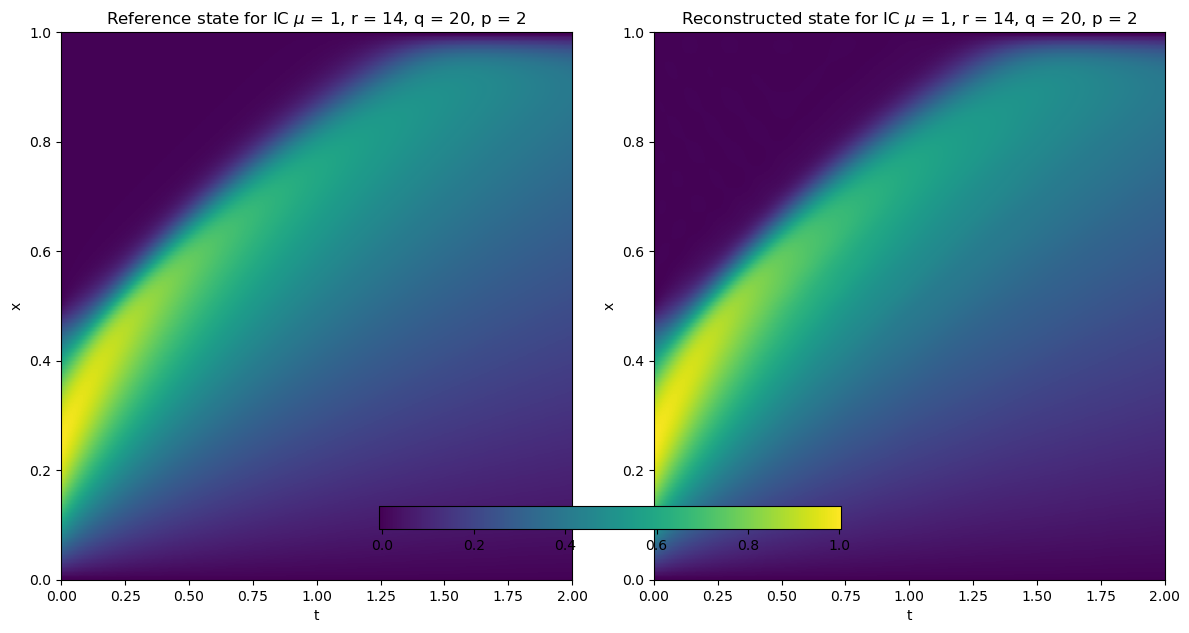

In [22]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end, int(X_all[2].shape[0])), np.linspace(0.0, 1.0, X_all[2].shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", X_all[2].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(X_all[2].T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for IC $\mu$ = {mus[2]}, r = {r}, q = {q_trunc}, p = {p}')
    
    c2 = axs[1].imshow(s_rec, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Reconstructed state for IC $\mu$ = {mus[2]}, r = {r}, q = {q_trunc}, p = {p}')
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(X_all[2]), np.min(s_rec)])
    vmax = np.max([np.max(X_all[2]), np.max(s_rec)])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()

In [23]:
# calculate the relative error
rel_error = np.linalg.norm(X_all[2][:-1].T - s_rec, 'fro') / np.linalg.norm(X_all[2].T - X_ref, 'fro')
print(f"Relative error: {rel_error:.4%}")

Relative error: 1.0546%


In [24]:
# compute the full time series
coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)
IC = np.array([initial_condition(c) for c in coord])
q0 = Vr.T @ (IC[:, None] - X_ref).flatten()

T_end_full = 8
time_domain_full = np.arange(0, T_end_full, dt)

multi_indices = generate_multi_indices_efficient(len(q0), p=p)

out_full = scipy.integrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain_full[0], time_domain_full[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain_full,  # evaluated at these points
            args=[operators, multi_indices, None],  # additional arguments to rhs
        )

s_hat_full = out_full.y
poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
print("Poly shape: ", poly.shape)

s_rec_full = X_ref.reshape(-1, 1) + Vr @ s_hat_full + Vbar @ Xi @ poly_full

coord =  (130,)
Poly shape:  (14, 2000)


In [25]:
X_all_full = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE100.npy")

In [26]:
X_all_full[2].shape

(8000, 130)

In [27]:
# import matplotlib.animation as animation

# fig = plt.figure()

# def update_plot(i, data):
#     plt.clf()
#     plt.plot(data[i])
#     plt.xlabel('x')
#     plt.ylabel('u')
#     plt.title(f'Reconstructed state for IC $\mu$ = {mus[2]}, time = {i*dt}')

# ani = animation.FuncAnimation(fig, update_plot, frames=range(X_all_full[2].shape[0]), fargs=(s_rec_full.T,), interval=100)

# # save the animation
# ani.save('burgers_reconstruction.mp4')

X =  (130, 8000)
Y =  (130, 8000)
s_ref_all[i] =  (2001, 130)


/tmp/ipykernel_1891330/3107959281.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


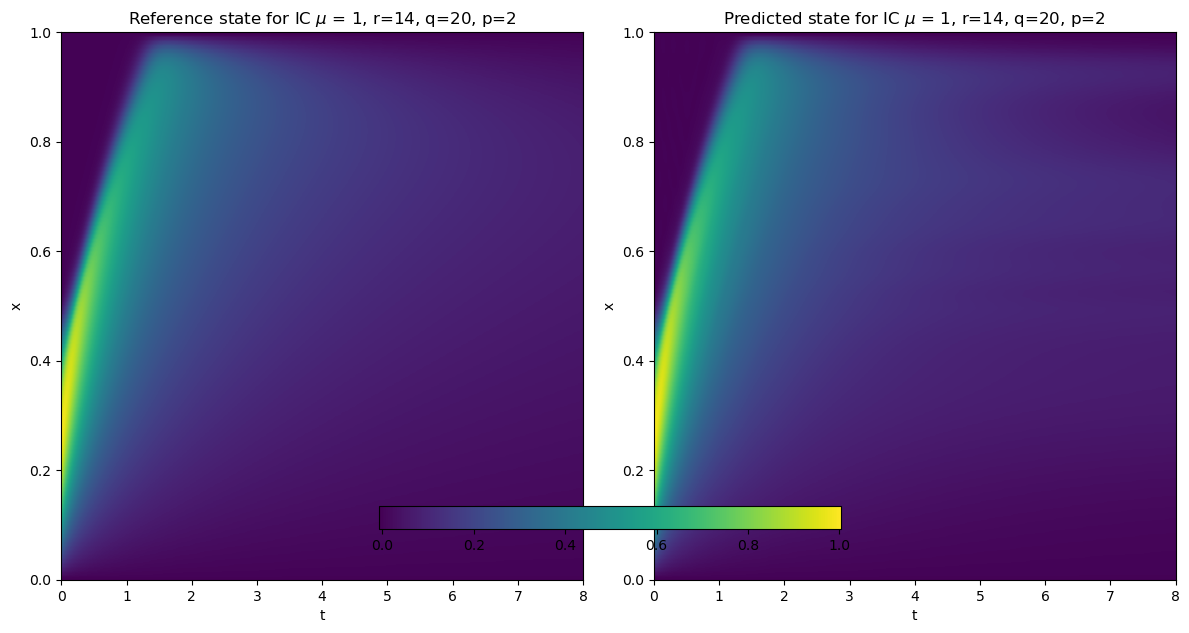

In [28]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(X_all_full[2].shape[0])), np.linspace(0.0, 1.0, X_all_full[2].shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", X_all[2].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(X_all_full[2].T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # ZZ = X_all_full[2].T
    # c1 = axs[0].contourf(XX, YY, ZZ, 100, cmap='viridis')
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}')
    
    c2 = axs[1].imshow(s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # zz = s_rec_full
    # c2 = axs[1].contourf(XX, YY, zz, 100, cmap='viridis')
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Predicted state for IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}')  
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(X_all[2]), np.min(s_rec)])
    vmax = np.max([np.max(X_all[2]), np.max(s_rec)])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()

In [29]:
X_all_full[2].T.shape

(130, 8000)

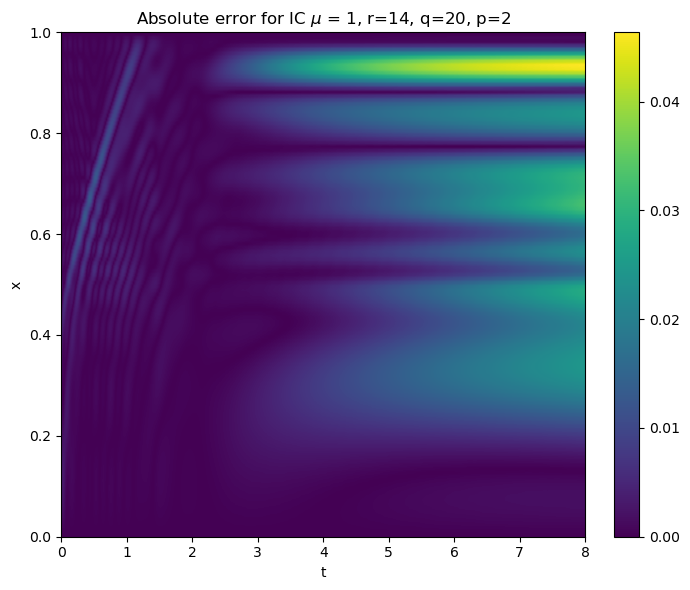

In [30]:
# calculate absolute error after the training window
abs_error_full = np.abs(X_all_full[2].T - s_rec_full)
relative_error_window = np.linalg.norm(X_all_full[2].T[:, T_end:] - s_rec_full[:, T_end:], 'fro') / np.linalg.norm(X_all_full[2].T[:, T_end:], 'fro')

# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 1, figsize=(7, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(X_all_full[2].shape[0])), np.linspace(0.0, 1.0, X_all_full[2].shape[1]))
    
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs.imshow(abs_error_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # ZZ = X_all_full[2].T
    # c1 = axs[0].contourf(XX, YY, ZZ, 100, cmap='viridis')
    # fig.colorbar(c)
    axs.set_xlabel('t')
    axs.set_ylabel('x')
    axs.set_title(f'Absolute error for IC $\mu$ = {mus[2]}, r={r}, q={q_trunc}, p={p}')
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(abs_error_full)])
    vmax = np.max([np.max(abs_error_full)])
    c1.set_clim(vmin=vmin, vmax=vmax)

    
    fig.colorbar(c1, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()

In [31]:
print(relative_error_window)

0.052111208507826315
